In [2]:
import os
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random



from matplotlib.ticker import FuncFormatter

import pickle




time_1 = datetime.datetime.now()
warnings.filterwarnings('ignore')

plt.rcParams["font.family"]='Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['figure.figsize'] = (18,8)   
plt.rcParams['figure.dpi'] = 300.0  # 分辨率
plt.rcParams['savefig.dpi'] = 300.0  # 图片像素

harvest_red = '#a50000'
harvest_gray = '#b5b6b6'

warnings.filterwarnings('ignore')
######################################################################
os.chdir('./data')
######################################################################

针对X的处理

In [11]:
X = pd.read_excel('data.xlsx',sheet_name = '利率')
X = X.rename(columns = {'指标名称':'日期'})
X['日期'] = pd.to_datetime(X['日期']).apply(lambda x:int(x.strftime('%Y%m%d')))
X.index = pd.to_datetime(X['日期'].astype(str))
del X['日期']
X = X.interpolate()

X = X.pct_change(periods=12)*100
# X = X.shift(1).interpolate()
X = X[X['美国:国债收益率:1个月']!=float('inf')]
X = X[X['美国:国债收益率:3个月']!=float('inf')]
X=X.dropna()
X_copy = X.copy()
# for i in X.columns:
#     res = sm.tsa.seasonal_decompose(X[i])
#     X_copy[i] = res.trend
X_copy = X_copy.dropna()

针对Y的处理

In [60]:
y = pd.read_excel('data.xlsx',sheet_name = '资产价格') 
y['日期'] = pd.to_datetime(y['日期']).apply(lambda x:int(x.strftime('%Y%m%d')))
y_copy = y[y['日期'].isin(list(map(lambda x:int(x.strftime('%Y%m%d')),list(X_copy.index))))]
y_copy[['恒生指数', '恒生科技', '恒生中国企业指数']] = y_copy[['恒生指数', '恒生科技', '恒生中国企业指数']].transform(np.log)
y_copy = y_copy.sort_values('日期',ascending = True)
y_copy[['恒生指数', '恒生科技', '恒生中国企业指数']] = y_copy[['恒生指数', '恒生科技','恒生中国企业指数']] - y_copy[['恒生指数', '恒生科技', '恒生中国企业指数']].shift(12)
y_copy[['恒生指数', '恒生科技', '恒生中国企业指数']] = y_copy[['恒生指数', '恒生科技', '恒生中国企业指数']]*100
y_copy['日期'] = pd.to_datetime(y_copy['日期'].astype(str))
y_copy.index = y_copy['日期']
y_copy = y_copy.drop('日期',axis = 1)

In [61]:
data_set = pd.merge(pd.DataFrame(y_copy['恒生指数'].dropna()),
                    X_copy,
                    left_index = True,
                    right_index = True)

恒生指数

In [67]:
data_set = pd.merge(pd.DataFrame(y_copy['恒生指数'].dropna()),
                    X_copy,
                    left_index = True,
                    right_index = True)
meidian_for_all = pd.DataFrame()
for j in data_set.columns[1:]:

    list_total = []
    beta_list = []
    t_list = []
    r2_list = []
    for i in range(1000):
        random_seed = random.randint(0,len(data_set)-731)
        y = data_set.iloc[random_seed:random_seed+730]['恒生指数'].values.reshape(730,1)
        x = data_set.iloc[random_seed:random_seed+730][j].values.reshape(730,1)
        model = sm.OLS(y, x)
        res = model.fit()
        res = res.get_robustcov_results(cov_type='HAC',maxlags=1)
        beta = res.params[0]
        t = res.tvalues[0]
        r2 = res.rsquared
        beta_list.append(beta)
        t_list.append(t)
        r2_list.append(r2)
    list_total.append(np.median(beta_list))
    list_total.append(np.median(t_list))
    list_total.append(np.median(r2_list))
    list_total = pd.DataFrame(list_total).T
    list_total.columns = ['beta','t','r2']
    list_total.index = [j]
    meidian_for_all = meidian_for_all.append(list_total)     
hang_seng_index = meidian_for_all

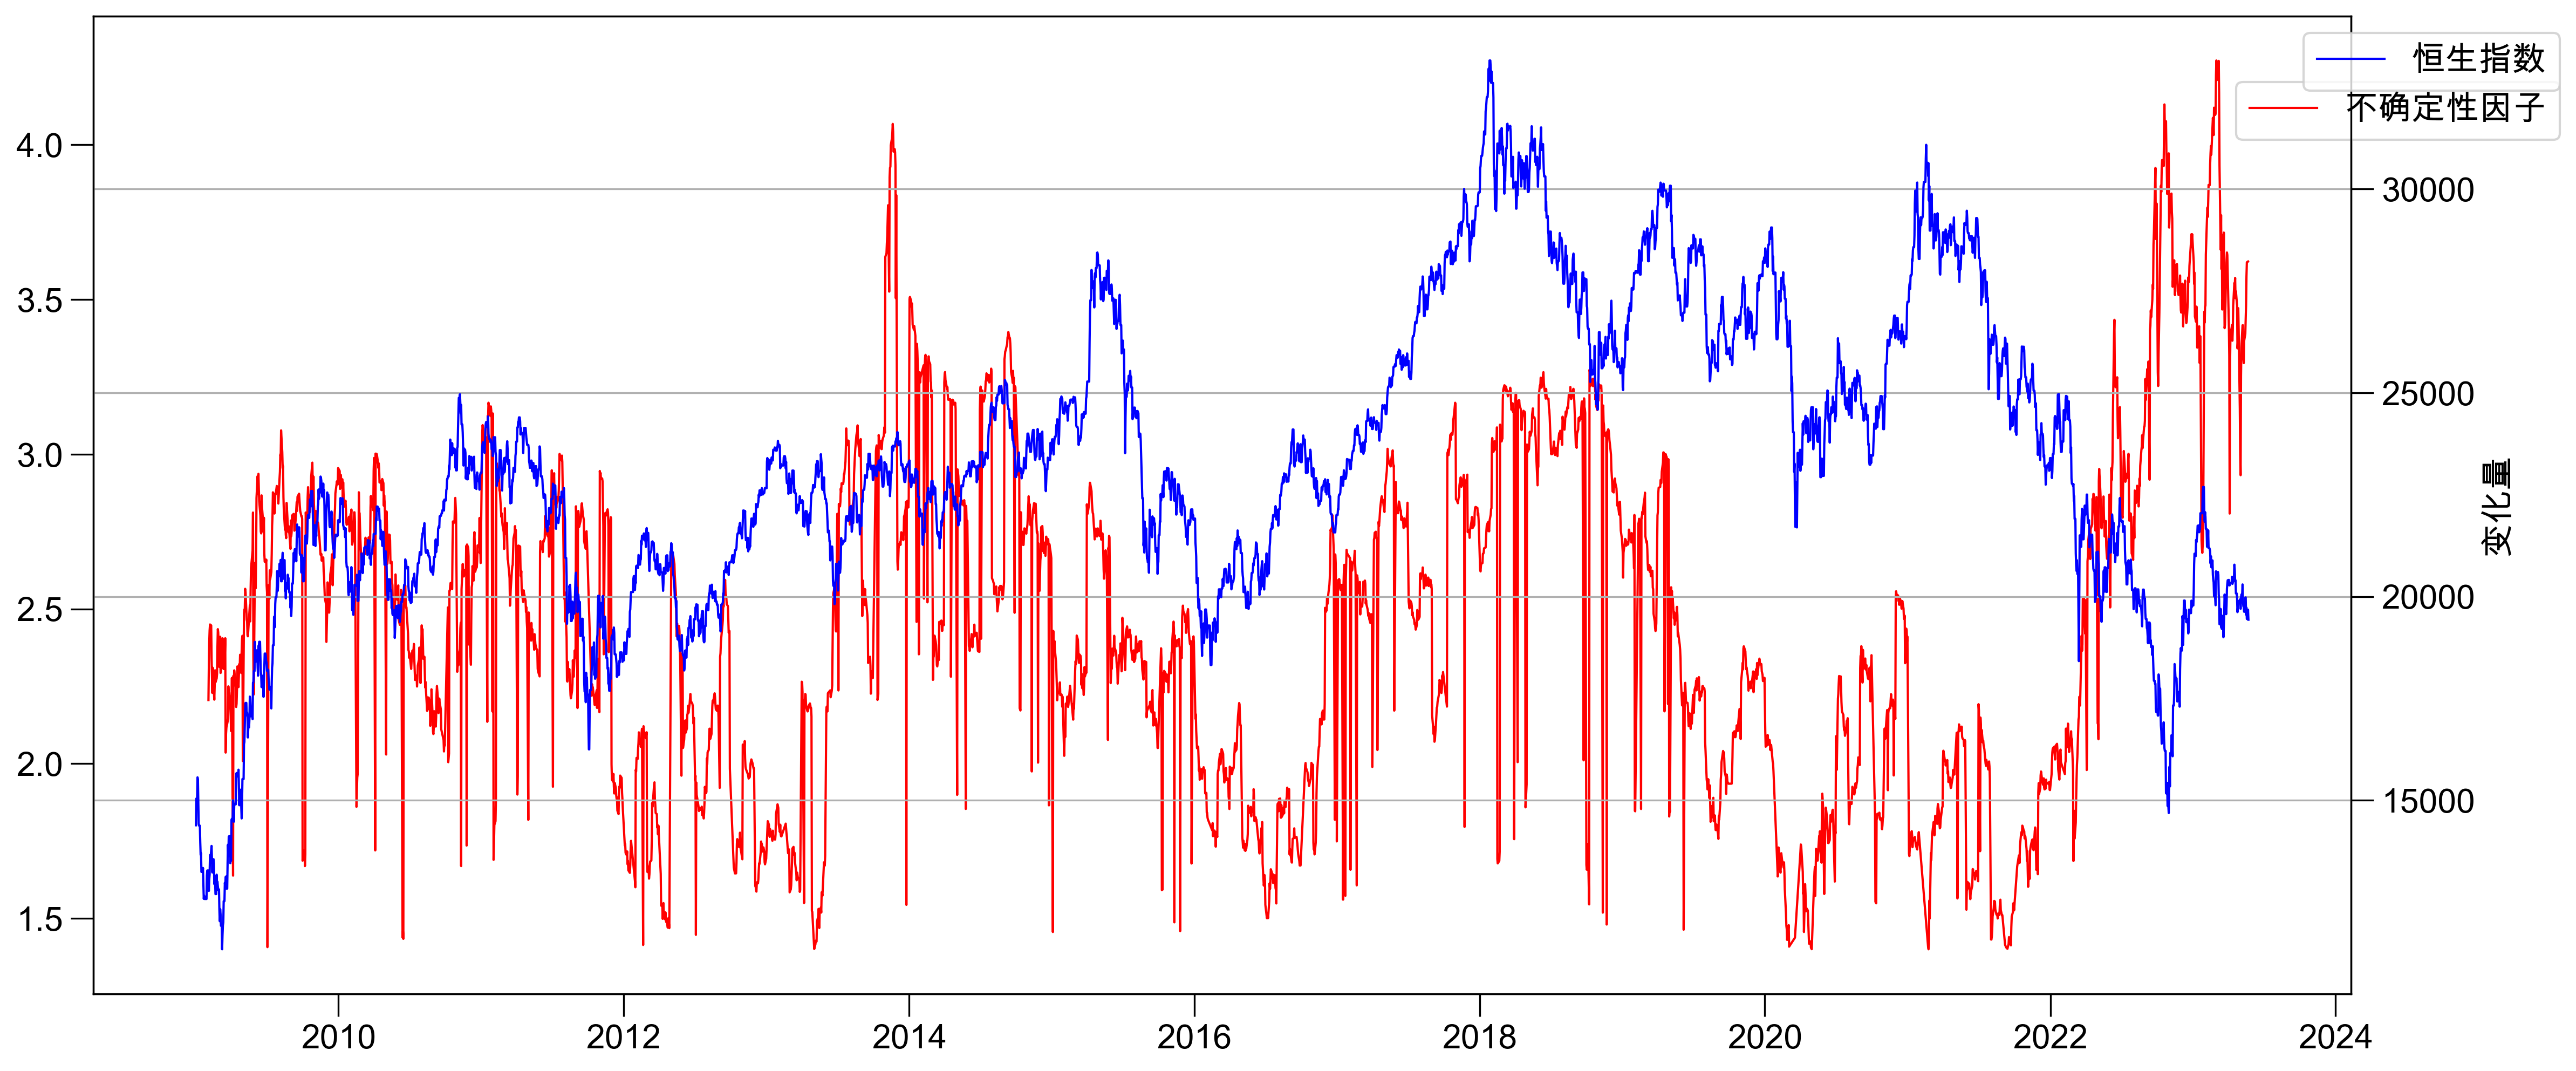

In [226]:
factor_list = hang_seng_index[hang_seng_index['t'].abs()>2].index
X = pd.read_excel('data.xlsx',sheet_name = '利率')
X = X.rename(columns = {'指标名称':'日期'})
X['日期'] = pd.to_datetime(X['日期']).apply(lambda x:int(x.strftime('%Y%m%d')))
X.index = pd.to_datetime(X['日期'].astype(str))
del X['日期']
X_std = X[factor_list].resample('M').std().resample('D').fillna(method = 'bfill')
X = X.reset_index()
X_std = X_std.reset_index()
values_for_draw = pd.DataFrame((X[X['日期'].isin(X_std['日期'])][factor_list].values*X_std[X_std['日期'].isin(X['日期'])][factor_list].values)/X_std[X_std['日期'].isin(X['日期'])][factor_list].T.sum().values.reshape(3815,1)).T.sum()
data_for_draw = pd.DataFrame(values_for_draw).rename(columns = {0:'合成指数'})
data_for_draw.index = pd.merge(X_std,X,how = 'inner',on = '日期')['日期']
data_for_draw = data_for_draw[data_for_draw['合成指数']>1.4]
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax1=ax.twinx()   
y = pd.read_excel('data.xlsx',sheet_name = '资产价格') 
ax.plot(data_for_draw.index,data_for_draw['合成指数'],
         linestyle='-',  linewidth=1,color ='red',label = '不确定性因子')
ax1.plot(y['日期'],y['恒生指数'],
         linestyle='-', linewidth=1,color = 'blue',label = '恒生指数')

plt.grid()
ax.legend(fontsize=15,loc=1,bbox_to_anchor=(1.1,0.95))
ax1.legend(fontsize=15,loc=1,bbox_to_anchor=(1.1,1.0))
plt.xlabel('start_date')
plt.ylabel('变化量')
#plt.ylim(0,150)
plt.savefig('图例.jpg')

恒生科技	

In [64]:
data_set = pd.merge(pd.DataFrame(y_copy['恒生科技'].dropna()),
                    X_copy,
                    left_index = True,
                    right_index = True)
meidian_for_all = pd.DataFrame()
for j in data_set.columns[1:]:

    list_total = []
    beta_list = []
    t_list = []
    r2_list = []
    for i in range(1000):
        random_seed = random.randint(0,len(data_set)-731)
        y = data_set.iloc[random_seed:random_seed+730]['恒生科技'].values.reshape(730,1)
        x = data_set.iloc[random_seed:random_seed+730][j].values.reshape(730,1)
        model = sm.OLS(y, x)
        res = model.fit()
        res = res.get_robustcov_results(cov_type='HAC',maxlags=1)
        beta = res.params[0]
        t = res.tvalues[0]
        r2 = res.rsquared
        beta_list.append(beta)
        t_list.append(t)
        r2_list.append(r2)
    list_total.append(np.median(beta_list))
    list_total.append(np.median(t_list))
    list_total.append(np.median(r2_list))
    list_total = pd.DataFrame(list_total).T
    list_total.columns = ['beta','t','r2']
    list_total.index = [j]
    meidian_for_all = meidian_for_all.append(list_total)  
hang_seng_technology_index = meidian_for_all

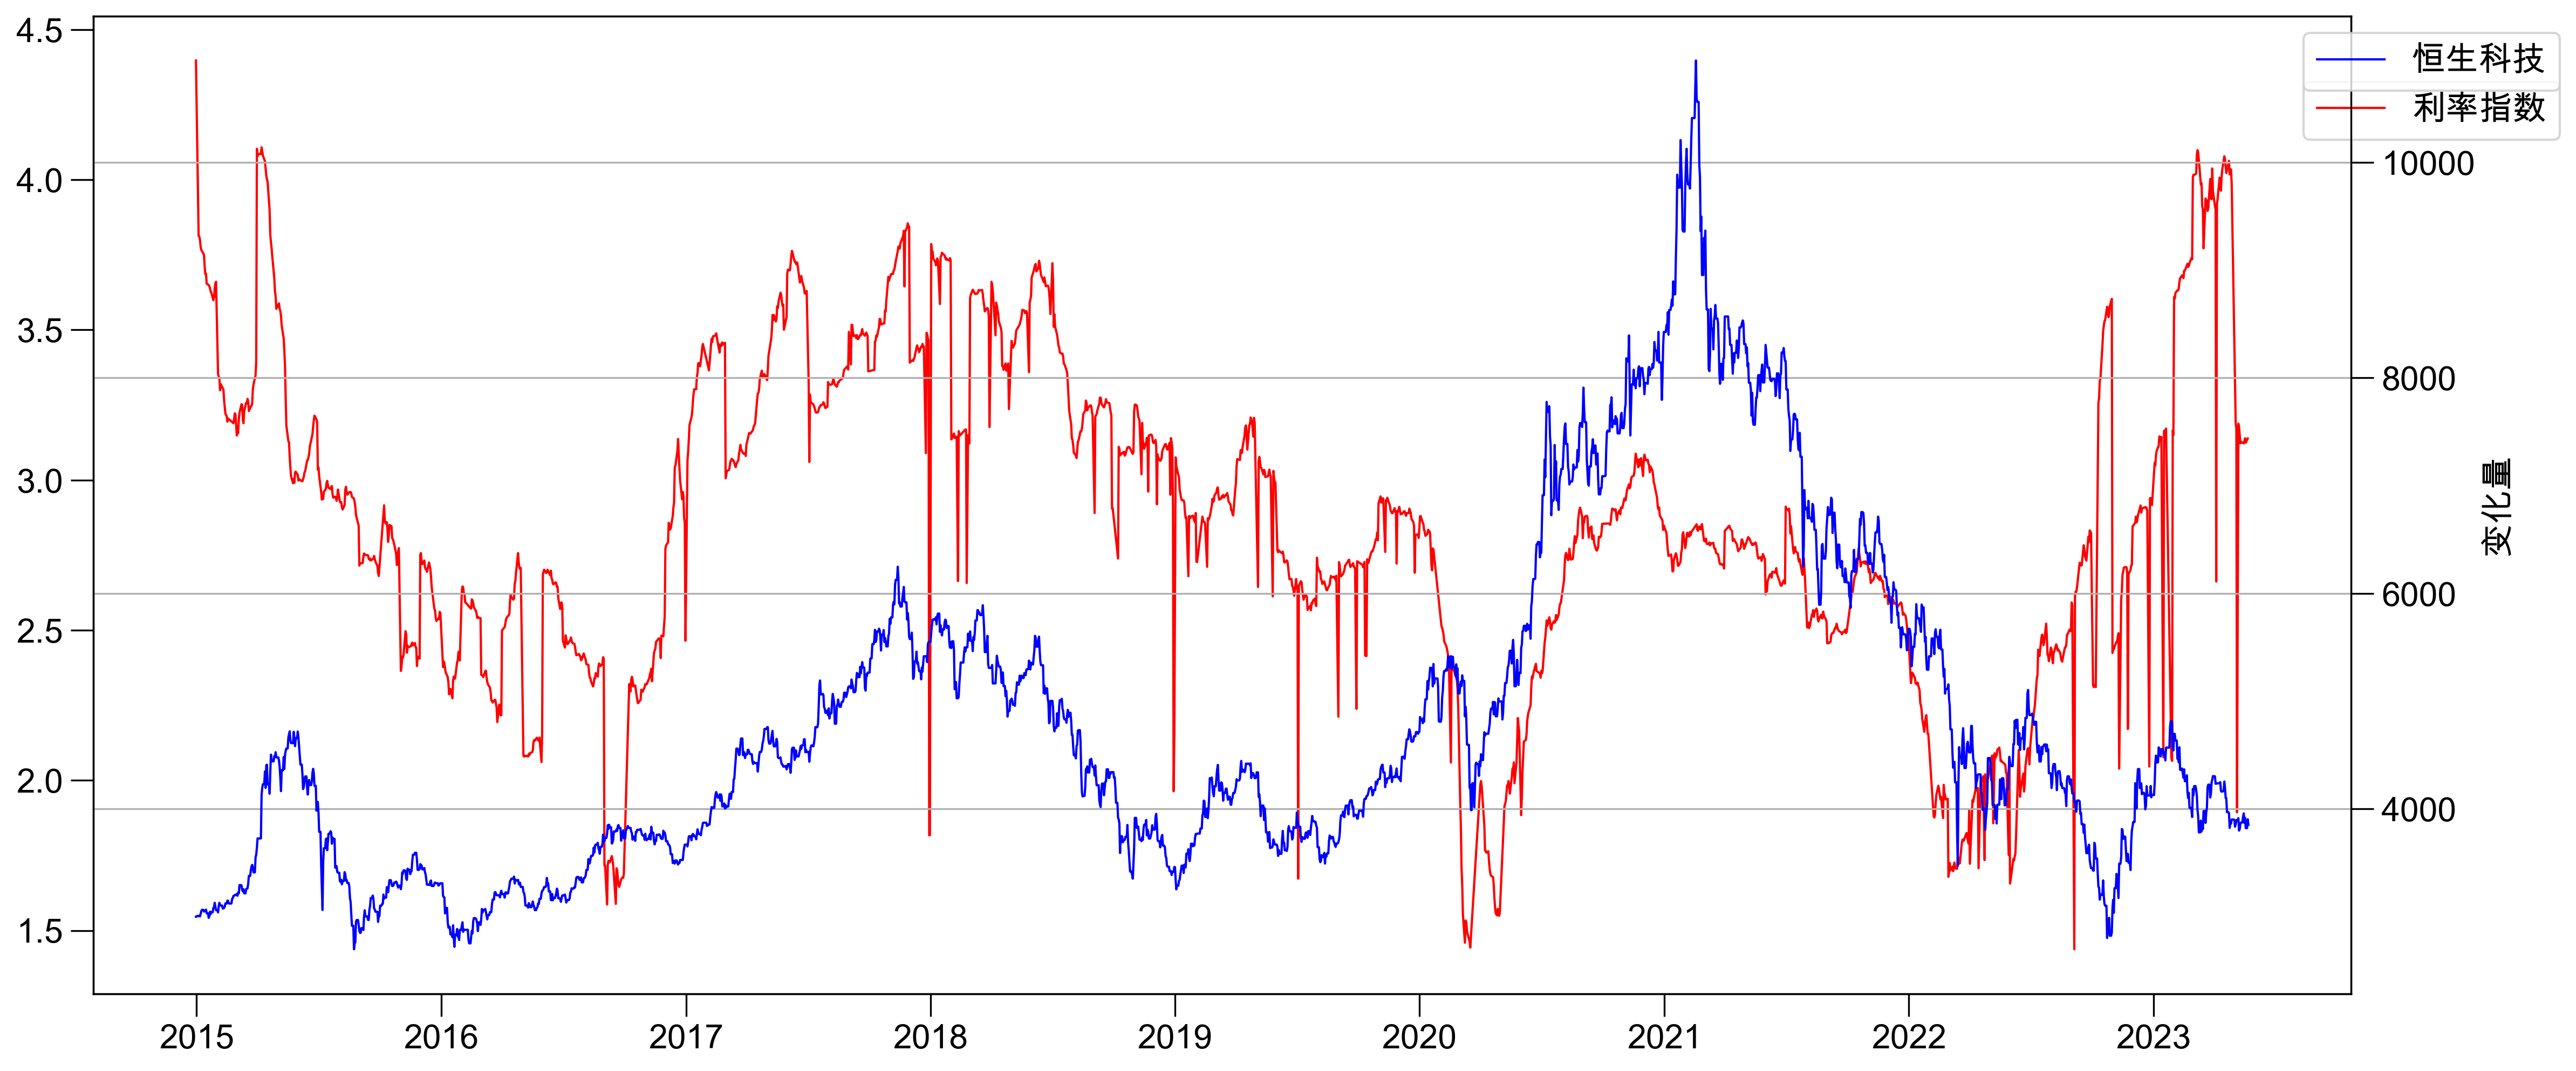

In [237]:
factor_list = hang_seng_technology_index[hang_seng_technology_index['t'].abs()>2].index
X = pd.read_excel('data.xlsx',sheet_name = '利率')
X = X.rename(columns = {'指标名称':'日期'})
X['日期'] = pd.to_datetime(X['日期']).apply(lambda x:int(x.strftime('%Y%m%d')))
X.index = pd.to_datetime(X['日期'].astype(str))
del X['日期']
X_std = X[factor_list].resample('M').std().resample('D').fillna(method = 'bfill')
X = X.reset_index()
X_std = X_std.reset_index()
values_for_draw = pd.DataFrame((X[X['日期'].isin(X_std['日期'])][factor_list].values*X_std[X_std['日期'].isin(X['日期'])][factor_list].values)/X_std[X_std['日期'].isin(X['日期'])][factor_list].T.sum().values.reshape(3815,1)).T.sum()
data_for_draw = pd.DataFrame(values_for_draw).rename(columns = {0:'合成指数'})
data_for_draw.index = pd.merge(X_std,X,how = 'inner',on = '日期')['日期']
data_for_draw = data_for_draw[data_for_draw['合成指数']>1.4]
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax1=ax.twinx()   
y = pd.read_excel('data.xlsx',sheet_name = '资产价格') 
data_for_draw = data_for_draw.reset_index()
data_for_draw = data_for_draw[data_for_draw['日期'].isin(y.dropna()['日期'])]
ax.plot(data_for_draw['日期'],data_for_draw['合成指数'],
         linestyle='-',  linewidth=1,color ='red',label = '利率指数')
ax1.plot(y['日期'],y['恒生科技'],
         linestyle='-', linewidth=1,color = 'blue',label = '恒生科技')

plt.grid()
ax.legend(fontsize=15,loc=1,bbox_to_anchor=(1.1,0.95))
ax1.legend(fontsize=15,loc=1,bbox_to_anchor=(1.1,1.0))
plt.xlabel('start_date')
plt.ylabel('变化量')
#plt.ylim(0,150)
plt.savefig('图例.jpg')

In [24]:
# X = X.reset_index()
# X['Y'] = X['日期'].apply(lambda x:x.strftime('%Y'))
# merge = X.groupby('Y')[['中国:经济政策不确定性指数:新闻指数','美国:经济政策不确定性指数:总指数','中国香港:经济政策不确定性指数']].std()
# merge = merge.reset_index()
# data = []
# for i in ['中国:经济政策不确定性指数:新闻指数','美国:经济政策不确定性指数:总指数','中国香港:经济政策不确定性指数']:
    
#     data_one = pd.merge(X[['日期','Y',i]],
#              merge[['Y',i]],
#              on = 'Y',
#              how = 'left')
#     data_one[i+'_value'] = data_one[i+'_x']/data_one[i+'_y']
#     data_one.index= data_one['日期']
#     data.append(data_one[[i+'_value']])
# data = pd.DataFrame(data[0].values+data[1].values+data[2].values,index = data[0].index)
# y = pd.read_excel('data.xlsx',sheet_name = '资产价格') 
# data = data.reset_index()
# data = data[data['日期'].apply(lambda x:int(x.strftime('%Y%m%d')))>20150000]
# data[0] = data[0].shift(1)
# fig = plt.figure(figsize=(18,8))
# ax = fig.add_subplot(111)
# ax1=ax.twinx()   
# ax.plot(data['日期'],data[0],
#          linestyle='-',  linewidth=1,color ='red',label = '不确定性因子')
# ax1.plot(y['日期'],y['恒生科技'],
#          linestyle='-', linewidth=1,color = 'blue',label = '恒生科技')

# plt.grid()
# ax.legend(fontsize=15,loc=1,bbox_to_anchor=(1.1,0.95))
# ax1.legend(fontsize=15,loc=1,bbox_to_anchor=(1.1,1.0))
# plt.xlabel('start_date')
# plt.ylabel('变化量')
# #plt.ylim(0,150)
# plt.savefig('图例.jpg')

恒生中国


In [73]:
data_set = pd.merge(pd.DataFrame(y_copy['恒生中国企业指数'].dropna()),
                    X_copy,
                    left_index = True,
                    right_index = True)
meidian_for_all = pd.DataFrame()
for j in data_set.columns[1:]:

    list_total = []
    beta_list = []
    t_list = []
    r2_list = []
    for i in range(1000):
        random_seed = random.randint(0,len(data_set)-731)
        y = data_set.iloc[random_seed:random_seed+730]['恒生中国企业指数'].values.reshape(730,1)
        x = data_set.iloc[random_seed:random_seed+730][j].values.reshape(730,1)
        model = sm.OLS(y, x)
        res = model.fit()
        res = res.get_robustcov_results(cov_type='HAC',maxlags=1)
        beta = res.params[0]
        t = res.tvalues[0]
        r2 = res.rsquared
        beta_list.append(beta)
        t_list.append(t)
        r2_list.append(r2)
    list_total.append(np.median(beta_list))
    list_total.append(np.median(t_list))
    list_total.append(np.median(r2_list))
    list_total = pd.DataFrame(list_total).T
    list_total.columns = ['beta','t','r2']
    list_total.index = [j]
    meidian_for_all = meidian_for_all.append(list_total)  
hang_seng_china_index = meidian_for_all

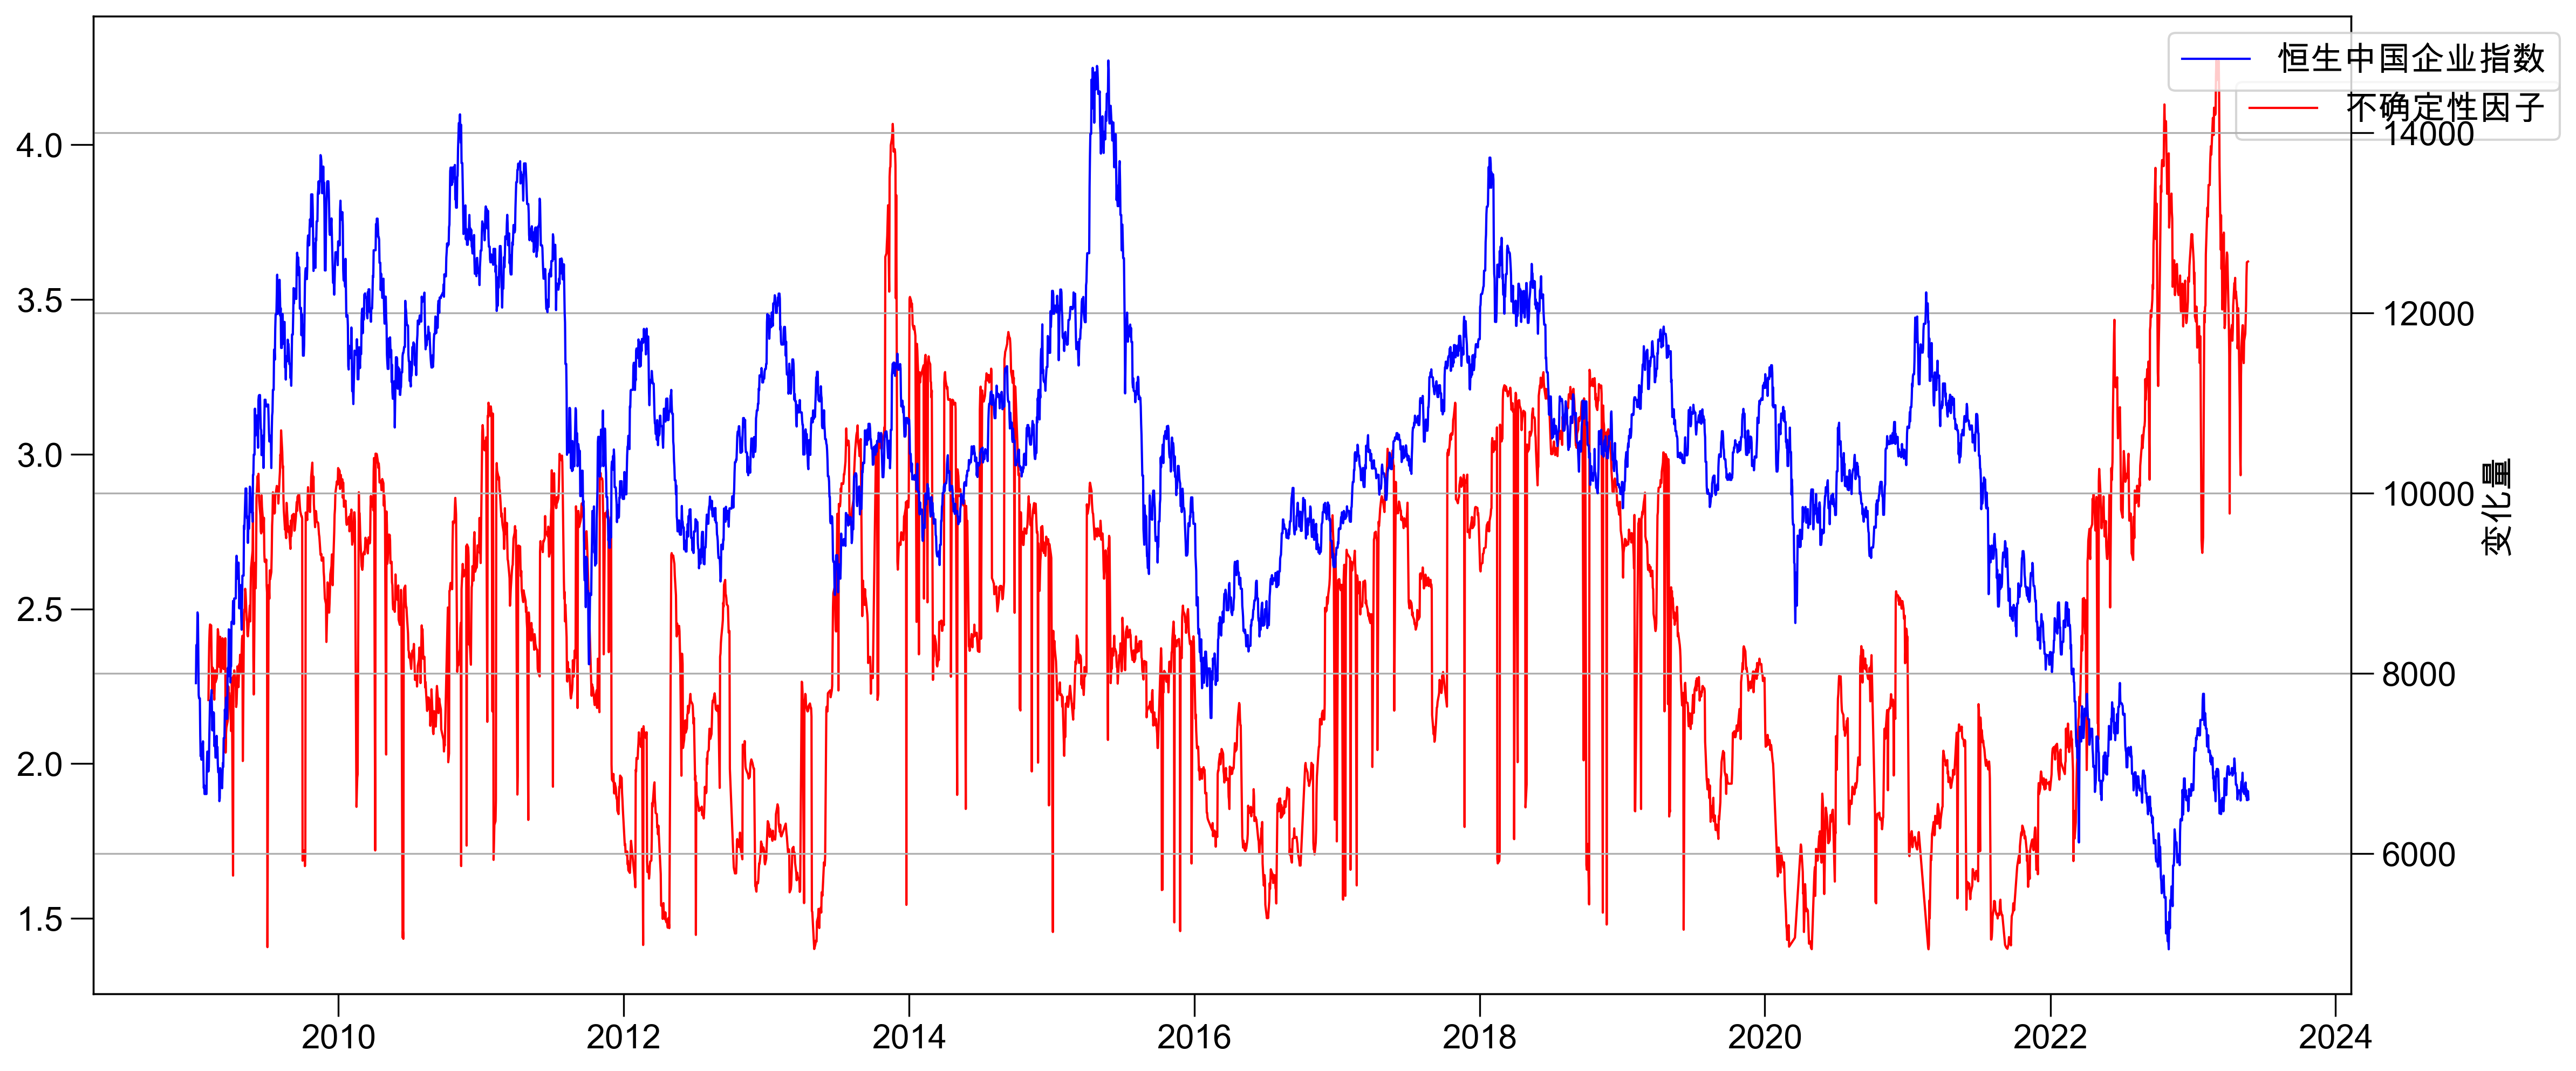

In [229]:
factor_list = hang_seng_china_index[hang_seng_china_index['t'].abs()>2].index
X = pd.read_excel('data.xlsx',sheet_name = '利率')
X = X.rename(columns = {'指标名称':'日期'})
X['日期'] = pd.to_datetime(X['日期']).apply(lambda x:int(x.strftime('%Y%m%d')))
X.index = pd.to_datetime(X['日期'].astype(str))
del X['日期']
X_std = X[factor_list].resample('M').std().resample('D').fillna(method = 'bfill')
X = X.reset_index()
X_std = X_std.reset_index()
values_for_draw = pd.DataFrame((X[X['日期'].isin(X_std['日期'])][factor_list].values*X_std[X_std['日期'].isin(X['日期'])][factor_list].values)/X_std[X_std['日期'].isin(X['日期'])][factor_list].T.sum().values.reshape(3815,1)).T.sum()
data_for_draw = pd.DataFrame(values_for_draw).rename(columns = {0:'合成指数'})
data_for_draw.index = pd.merge(X_std,X,how = 'inner',on = '日期')['日期']
data_for_draw = data_for_draw[data_for_draw['合成指数']>1.4]
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax1=ax.twinx()   
y = pd.read_excel('data.xlsx',sheet_name = '资产价格') 
ax.plot(data_for_draw.index,data_for_draw['合成指数'],
         linestyle='-',  linewidth=1,color ='red',label = '不确定性因子')
ax1.plot(y['日期'],y['恒生中国企业指数'],
         linestyle='-', linewidth=1,color = 'blue',label = '恒生中国企业指数')

plt.grid()
ax.legend(fontsize=15,loc=1,bbox_to_anchor=(1.1,0.95))
ax1.legend(fontsize=15,loc=1,bbox_to_anchor=(1.1,1.0))
plt.xlabel('start_date')
plt.ylabel('变化量')
#plt.ylim(0,150)
plt.savefig('图例.jpg')

In [75]:
# 打开一个 Excel 文件
work = pd.ExcelWriter('利率.xlsx')

# 保存第一个表
hang_seng_china_index.to_excel(work, sheet_name='恒生中国')
hang_seng_index.to_excel(work, sheet_name='恒生指数')
hang_seng_technology_index.to_excel(work, sheet_name='科技指数')

# 数据持久化

work.save()




In [3]:
indus = pd.read_excel('行业表现.xlsx')

In [4]:
def day_2_int(x):
    return int(x.strftime('%Y%m%d'))
def int_2_day(x):
    return datetatime.date(str(x)[:4],str(x)[4:6],str(x)[6:])

In [5]:
indus = indus[indus['日期'].transform(day_2_int)>2010]

In [6]:
X = pd.read_excel('data.xlsx',sheet_name = '利率')
X.index = X['指标名称']
trail = X[['美国:国债收益率:10年','中国:中债国债到期收益率:10年']]
for i in range(1,10,1):
    trail['factor 中{}美{}'.format(str(i/10),str((10-i)/10))] = trail['中国:中债国债到期收益率:10年']*i/10+trail['美国:国债收益率:10年']*(1-i/10)
trail = trail.reset_index().rename(columns = {'指标名称':'日期'})

In [7]:
indus = pd.merge(indus,
                trail,
                on = '日期',
                how = 'left')

In [8]:
factors_data = indus[['日期','增长因子', '6MMA', '市场风险因子', '6MMA.1', '利率因子', '6MMA.2']].copy()
indexes_data = indus[['日期','香港能源Ⅱ', '香港材料Ⅱ', '香港资本货物', '香港商业和专业服务', '香港运输', '香港汽车与汽车零部件',
       '香港耐用消费品与服装', '香港消费者服务Ⅱ', '香港媒体Ⅱ', '香港零售业', '香港食品与主要用品零售Ⅱ',
       '香港食品、饮料与烟草', '香港家庭与个人用品', '香港医疗保健设备与服务', '香港制药、生物科技与生命科学', '香港银行',
       '香港多元金融', '香港保险Ⅱ', '香港房地产Ⅱ', '香港软件与服务', '香港技术硬件与设备', '香港半导体与半导体生产设备',
       '香港电信服务Ⅱ', '香港公用事业Ⅱ', '香港能源Ⅱ.1', '香港材料Ⅱ.1', '香港资本货物.1',
       '香港商业和专业服务.1', '香港运输.1', '香港汽车与汽车零部件.1', '香港耐用消费品与服装.1', '香港消费者服务Ⅱ.1',
       '香港媒体Ⅱ.1', '香港零售业.1', '香港食品与主要用品零售Ⅱ.1', '香港食品、饮料与烟草.1', '香港家庭与个人用品.1',
       '香港医疗保健设备与服务.1', '香港制药、生物科技与生命科学.1', '香港银行.1', '香港多元金融.1', '香港保险Ⅱ.1',
       '香港房地产Ⅱ.1', '香港软件与服务.1', '香港技术硬件与设备.1', '香港半导体与半导体生产设备.1', '香港电信服务Ⅱ.1',
       '香港公用事业Ⅱ.1']].copy()

In [21]:
for j in ['增长因子']:
    trail_list = pd.DataFrame()
    for i in ['香港能源Ⅱ', '香港材料Ⅱ', '香港资本货物', '香港商业和专业服务', '香港运输', '香港汽车与汽车零部件',
           '香港耐用消费品与服装', '香港消费者服务Ⅱ', '香港媒体Ⅱ', '香港零售业', '香港食品与主要用品零售Ⅱ',
           '香港食品、饮料与烟草', '香港家庭与个人用品', '香港医疗保健设备与服务', '香港制药、生物科技与生命科学', '香港银行',
           '香港多元金融', '香港保险Ⅱ', '香港房地产Ⅱ', '香港软件与服务', '香港技术硬件与设备', '香港半导体与半导体生产设备',
           '香港电信服务Ⅱ', '香港公用事业Ⅱ', '香港能源Ⅱ.1', '香港材料Ⅱ.1', '香港资本货物.1',
           '香港商业和专业服务.1', '香港运输.1', '香港汽车与汽车零部件.1', '香港耐用消费品与服装.1', '香港消费者服务Ⅱ.1',
           '香港媒体Ⅱ.1', '香港零售业.1', '香港食品与主要用品零售Ⅱ.1', '香港食品、饮料与烟草.1', '香港家庭与个人用品.1',
           '香港医疗保健设备与服务.1', '香港制药、生物科技与生命科学.1', '香港银行.1', '香港多元金融.1', '香港保险Ⅱ.1',
           '香港房地产Ⅱ.1', '香港软件与服务.1', '香港技术硬件与设备.1', '香港半导体与半导体生产设备.1', '香港电信服务Ⅱ.1',
           '香港公用事业Ⅱ.1']:
        trail = pd.DataFrame(indus[['日期',i,j]].set_index('日期').resample('Y'))
        trail[1] = trail[1].apply(lambda x:x.corr()[i].loc[j])
        trail = trail.rename(columns = {0:'日期',1:i+'X'+j+'_'+'相关性'})
        trail_list = trail_list.append(trail.T)
    trail_list = trail_list.reset_index()
    trail_values = trail_list[trail_list['index'] != '日期']
    result = trail_values.T
    result.index = trail_list.iloc[0]
    result.columns = result.loc['日期']
    result = result.dropna()
#     result.to_excel(j+'相关性计算（年频).xlsx')

    

In [148]:
corr_data = indus[['日期','增长因子','市场风险因子','香港能源Ⅱ', '香港材料Ⅱ', '香港资本货物', '香港商业和专业服务', '香港运输', '香港汽车与汽车零部件',
           '香港耐用消费品与服装', '香港消费者服务Ⅱ', '香港媒体Ⅱ', '香港零售业', '香港食品与主要用品零售Ⅱ',
           '香港食品、饮料与烟草', '香港家庭与个人用品', '香港医疗保健设备与服务', '香港制药、生物科技与生命科学', '香港银行',
           '香港多元金融', '香港保险Ⅱ', '香港房地产Ⅱ', '香港软件与服务', '香港技术硬件与设备', '香港半导体与半导体生产设备',
           '香港电信服务Ⅱ', '香港公用事业Ⅱ', '香港能源Ⅱ.1', '香港材料Ⅱ.1', '香港资本货物.1',
           '香港商业和专业服务.1', '香港运输.1', '香港汽车与汽车零部件.1', '香港耐用消费品与服装.1', '香港消费者服务Ⅱ.1',
           '香港媒体Ⅱ.1', '香港零售业.1', '香港食品与主要用品零售Ⅱ.1', '香港食品、饮料与烟草.1', '香港家庭与个人用品.1',
           '香港医疗保健设备与服务.1', '香港制药、生物科技与生命科学.1', '香港银行.1', '香港多元金融.1', '香港保险Ⅱ.1',
           '香港房地产Ⅱ.1', '香港软件与服务.1', '香港技术硬件与设备.1', '香港半导体与半导体生产设备.1', '香港电信服务Ⅱ.1',
           '香港公用事业Ⅱ.1']].set_index('日期')

In [149]:
corr_data = corr_data.dropna()

In [150]:
index_list = ['香港能源Ⅱ.1', '香港材料Ⅱ.1', '香港资本货物.1',
           '香港商业和专业服务.1', '香港运输.1', '香港汽车与汽车零部件.1', '香港耐用消费品与服装.1', '香港消费者服务Ⅱ.1',
           '香港媒体Ⅱ.1', '香港零售业.1', '香港食品与主要用品零售Ⅱ.1', '香港食品、饮料与烟草.1', '香港家庭与个人用品.1',
           '香港医疗保健设备与服务.1', '香港制药、生物科技与生命科学.1', '香港银行.1', '香港多元金融.1', '香港保险Ⅱ.1',
           '香港房地产Ⅱ.1', '香港软件与服务.1', '香港技术硬件与设备.1', '香港半导体与半导体生产设备.1', '香港电信服务Ⅱ.1',
           '香港公用事业Ⅱ.1']

In [151]:
corr_total,t_total,r_total = [],[],[]
for j in index_list:
    corr = []
    t =  []
    r = []
    for i in range(1000):
        i=random.randint(0,len(corr_data)-84)
        x = corr_data['增长因子'].iloc[i:i+85]
        y = corr_data[j].iloc[i:i+85]
        model = sm.OLS(y, x)
        res = model.fit()
        res = res.get_robustcov_results(cov_type='HAC',maxlags=1)
        t1 = res.tvalues[0]
        r21 = res.rsquared
        corr1 = x.corr(y)
        t.append(t1)
        r.append(r21)
        corr.append(corr1)
    corr_total.append(np.median(corr))
    t_total.append(np.median(t))
    r_total.append(np.median(r))
pd.DataFrame([corr_total,t_total,r_total],columns = index_list,index = ['corr','t','r']).T.to_excel('增长因子计算结果.xlsx')


In [152]:
corr_total,t_total,r_total = [],[],[]
for j in index_list:
    corr = []
    t =  []
    r = []
    for i in range(1000):
        i=random.randint(0,len(corr_data)-84)
        x = corr_data['市场风险因子'].iloc[i:i+85]
        y = corr_data[j].iloc[i:i+85]
        model = sm.OLS(y, x)
        res = model.fit()
        res = res.get_robustcov_results(cov_type='HAC',maxlags=1)
        t1 = res.tvalues[0]
        r21 = res.rsquared
        corr1 = x.corr(y)
        t.append(t1)
        r.append(r21)
        corr.append(corr1)
    corr_total.append(np.median(corr))
    t_total.append(np.median(t))
    r_total.append(np.median(r))
pd.DataFrame([corr_total,t_total,r_total],columns = index_list,index = ['corr','t','r']).T.to_excel('市场风险因子计算结果.xlsx')



In [156]:
corr_data = indus[['日期','利率因子','香港能源Ⅱ.1', '香港材料Ⅱ.1', '香港资本货物.1',
           '香港商业和专业服务.1', '香港运输.1', '香港汽车与汽车零部件.1', '香港耐用消费品与服装.1', '香港消费者服务Ⅱ.1',
           '香港媒体Ⅱ.1', '香港零售业.1', '香港食品与主要用品零售Ⅱ.1', '香港食品、饮料与烟草.1', '香港家庭与个人用品.1',
           '香港医疗保健设备与服务.1', '香港制药、生物科技与生命科学.1', '香港银行.1', '香港多元金融.1', '香港保险Ⅱ.1',
           '香港房地产Ⅱ.1', '香港软件与服务.1', '香港技术硬件与设备.1', '香港半导体与半导体生产设备.1', '香港电信服务Ⅱ.1',
           '香港公用事业Ⅱ.1']].set_index('日期')
corr_data = corr_data.dropna()

In [157]:
corr_total,t_total,r_total = [],[],[]
for j in index_list:
    corr = []
    t =  []
    r = []
    for i in range(1000):
        i=random.randint(0,len(corr_data)-1820)
        x = corr_data['利率因子'].iloc[i:i+1820]
        y = corr_data[j].iloc[i:i+1820]
        model = sm.OLS(y, x)
        res = model.fit()
        res = res.get_robustcov_results(cov_type='HAC',maxlags=1)
        t1 = res.tvalues[0]
        r21 = res.rsquared
        corr1 = x.corr(y)
        t.append(t1)
        r.append(r21)
        corr.append(corr1)
    corr_total.append(np.median(corr))
    t_total.append(np.median(t))
    r_total.append(np.median(r))
pd.DataFrame([corr_total,t_total,r_total],columns = index_list,index = ['corr','t','r']).T.to_excel('利率因子计算结果.xlsx')




In [158]:
corr_data = indus[['日期','利率因子','增长因子','香港能源Ⅱ.1', '香港材料Ⅱ.1', '香港资本货物.1',
           '香港商业和专业服务.1', '香港运输.1', '香港汽车与汽车零部件.1', '香港耐用消费品与服装.1', '香港消费者服务Ⅱ.1',
           '香港媒体Ⅱ.1', '香港零售业.1', '香港食品与主要用品零售Ⅱ.1', '香港食品、饮料与烟草.1', '香港家庭与个人用品.1',
           '香港医疗保健设备与服务.1', '香港制药、生物科技与生命科学.1', '香港银行.1', '香港多元金融.1', '香港保险Ⅱ.1',
           '香港房地产Ⅱ.1', '香港软件与服务.1', '香港技术硬件与设备.1', '香港半导体与半导体生产设备.1', '香港电信服务Ⅱ.1',
           '香港公用事业Ⅱ.1']].set_index('日期')
corr_data = corr_data.dropna()

In [159]:
beta_interest_result,beta_growth_result,t_interest_result,t_growth_result,r2_result = [],[],[],[],[]
for j in index_list:
    t1_total = []
    t2_total = []
    r2_total = []
    b1_total = []
    b2_total = []
    for i in range(1000):
        i=random.randint(0,len(corr_data)-84)
        x = corr_data[['利率因子','增长因子']].iloc[i:i+84]
        y = corr_data[j].iloc[i:i+84]
        model = sm.OLS(y, x)
        res = model.fit()
        res = res.get_robustcov_results(cov_type='HAC',maxlags=1)
        beta_interest =res.params[0]
        beta_growth =res.params[1]
        t_interest = res.tvalues[0]
        t_growth =  res.tvalues[1]
        r2 = res.rsquared
        b1_total.append(beta_interest)
        b2_total.append(beta_growth)
        t1_total.append(t_interest)
        t2_total.append(t_growth)
        r2_total.append(r2)
    beta_interest_result.append(np.median(b1_total))   
    beta_growth_result.append(np.median(b2_total))   
    t_interest_result.append(np.median(t1_total))
    t_growth_result.append(np.median(t2_total))
    r2_result.append(np.median(r2_total))
pd.DataFrame([beta_interest_result,beta_growth_result,t_interest_result,t_growth_result,r2_result],columns = index_list,index = ['利率因子系数','增长因子系数','利率因子t值','增长因子t值','r2大小']).T.to_excel('利率因子X增长因子计算结果.xlsx')





In [146]:
pd.DataFrame([beta_interest_result,beta_growth_result,t_interest_result,t_growth_result,r2_result],columns = index_list,index = ['利率因子系数','增长因子系数','利率因子t值','增长因子t值','r2大小']).T.to_excel('利率因子X增长因子计算结果.xlsx')



In [ ]:
corr_data = indus[['日期','利率因子','香港能源Ⅱ', '香港材料Ⅱ', '香港资本货物', '香港商业和专业服务', '香港运输', '香港汽车与汽车零部件',
           '香港耐用消费品与服装', '香港消费者服务Ⅱ', '香港媒体Ⅱ', '香港零售业', '香港食品与主要用品零售Ⅱ',
           '香港食品、饮料与烟草', '香港家庭与个人用品', '香港医疗保健设备与服务', '香港制药、生物科技与生命科学', '香港银行',
           '香港多元金融', '香港保险Ⅱ', '香港房地产Ⅱ', '香港软件与服务', '香港技术硬件与设备', '香港半导体与半导体生产设备',
           '香港电信服务Ⅱ', '香港公用事业Ⅱ', '香港能源Ⅱ.1', '香港材料Ⅱ.1', '香港资本货物.1',
           '香港商业和专业服务.1', '香港运输.1', '香港汽车与汽车零部件.1', '香港耐用消费品与服装.1', '香港消费者服务Ⅱ.1',
           '香港媒体Ⅱ.1', '香港零售业.1', '香港食品与主要用品零售Ⅱ.1', '香港食品、饮料与烟草.1', '香港家庭与个人用品.1',
           '香港医疗保健设备与服务.1', '香港制药、生物科技与生命科学.1', '香港银行.1', '香港多元金融.1', '香港保险Ⅱ.1',
           '香港房地产Ⅱ.1', '香港软件与服务.1', '香港技术硬件与设备.1', '香港半导体与半导体生产设备.1', '香港电信服务Ⅱ.1',
           '香港公用事业Ⅱ.1']].set_index('日期')

In [74]:
result1=pd.DataFrame(result_total,index = ['香港能源Ⅱ', '香港材料Ⅱ', '香港资本货物', '香港商业和专业服务', '香港运输', '香港汽车与汽车零部件',
           '香港耐用消费品与服装', '香港消费者服务Ⅱ', '香港媒体Ⅱ', '香港零售业', '香港食品与主要用品零售Ⅱ',
           '香港食品、饮料与烟草', '香港家庭与个人用品', '香港医疗保健设备与服务', '香港制药、生物科技与生命科学', '香港银行',
           '香港多元金融', '香港保险Ⅱ', '香港房地产Ⅱ', '香港软件与服务', '香港技术硬件与设备', '香港半导体与半导体生产设备',
           '香港电信服务Ⅱ', '香港公用事业Ⅱ', '香港能源Ⅱ.1', '香港材料Ⅱ.1', '香港资本货物.1',
           '香港商业和专业服务.1', '香港运输.1', '香港汽车与汽车零部件.1', '香港耐用消费品与服装.1', '香港消费者服务Ⅱ.1',
           '香港媒体Ⅱ.1', '香港零售业.1', '香港食品与主要用品零售Ⅱ.1', '香港食品、饮料与烟草.1', '香港家庭与个人用品.1',
           '香港医疗保健设备与服务.1', '香港制药、生物科技与生命科学.1', '香港银行.1', '香港多元金融.1', '香港保险Ⅱ.1',
           '香港房地产Ⅱ.1', '香港软件与服务.1', '香港技术硬件与设备.1', '香港半导体与半导体生产设备.1', '香港电信服务Ⅱ.1',
           '香港公用事业Ⅱ.1']).sort_values(0,ascending = False).rename(columns = {0:'corr'})

In [78]:
result1 = result1.reset_index()

In [93]:
result1 = result1[result1['index'].str.contains('1')]
result1['index'] = result1['index'].apply(lambda x:x[:-2])
result1.to_excel('抽样检测结果.xlsx')

In [121]:
result_total = []
for j in ['利率因子', '6MMA.2','factor 中0.1美0.9',
       'factor 中0.2美0.8', 'factor 中0.3美0.7', 'factor 中0.4美0.6',
       'factor 中0.5美0.5', 'factor 中0.6美0.4', 'factor 中0.7美0.3',
       'factor 中0.8美0.2', 'factor 中0.9美0.1']:
    trail_list = pd.DataFrame()
    for i in ['香港能源Ⅱ', '香港材料Ⅱ', '香港资本货物', '香港商业和专业服务', '香港运输', '香港汽车与汽车零部件',
           '香港耐用消费品与服装', '香港消费者服务Ⅱ', '香港媒体Ⅱ', '香港零售业', '香港食品与主要用品零售Ⅱ',
           '香港食品、饮料与烟草', '香港家庭与个人用品', '香港医疗保健设备与服务', '香港制药、生物科技与生命科学', '香港银行',
           '香港多元金融', '香港保险Ⅱ', '香港房地产Ⅱ', '香港软件与服务', '香港技术硬件与设备', '香港半导体与半导体生产设备',
           '香港电信服务Ⅱ', '香港公用事业Ⅱ', '香港能源Ⅱ.1', '香港材料Ⅱ.1', '香港资本货物.1',
           '香港商业和专业服务.1', '香港运输.1', '香港汽车与汽车零部件.1', '香港耐用消费品与服装.1', '香港消费者服务Ⅱ.1',
           '香港媒体Ⅱ.1', '香港零售业.1', '香港食品与主要用品零售Ⅱ.1', '香港食品、饮料与烟草.1', '香港家庭与个人用品.1',
           '香港医疗保健设备与服务.1', '香港制药、生物科技与生命科学.1', '香港银行.1', '香港多元金融.1', '香港保险Ⅱ.1',
           '香港房地产Ⅱ.1', '香港软件与服务.1', '香港技术硬件与设备.1', '香港半导体与半导体生产设备.1', '香港电信服务Ⅱ.1',
           '香港公用事业Ⅱ.1']:
        trail = pd.DataFrame(indus[['日期',i,j]].set_index('日期').resample('M'))
        trail[1] = trail[1].apply(lambda x:x.corr()[i].loc[j])
        trail = trail.rename(columns = {0:'日期',1:i+'X'+j+'_'+'相关性'})
        trail_list = trail_list.append(trail.T)
    trail_list = trail_list.reset_index()
    trail_values = trail_list[trail_list['index'] != '日期']
    result = trail_values.T
    result.index = trail_list.iloc[0]
    result.columns = result.loc['日期']
    result = result.dropna()
    result.to_excel(j+'相关性计算（月频).xlsx')
    result_total.append(result.iloc[1:].mean())
    
    



In [122]:
output = result_total.copy()
for i in range(len(output)):
    output[i] = output[i].values


In [123]:
output = pd.DataFrame(output)
output.columns = ['香港能源Ⅱ', '香港材料Ⅱ', '香港资本货物', '香港商业和专业服务', '香港运输', '香港汽车与汽车零部件',
           '香港耐用消费品与服装', '香港消费者服务Ⅱ', '香港媒体Ⅱ', '香港零售业', '香港食品与主要用品零售Ⅱ',
           '香港食品、饮料与烟草', '香港家庭与个人用品', '香港医疗保健设备与服务', '香港制药、生物科技与生命科学', '香港银行',
           '香港多元金融', '香港保险Ⅱ', '香港房地产Ⅱ', '香港软件与服务', '香港技术硬件与设备', '香港半导体与半导体生产设备',
           '香港电信服务Ⅱ', '香港公用事业Ⅱ', '香港能源Ⅱ.1', '香港材料Ⅱ.1', '香港资本货物.1',
           '香港商业和专业服务.1', '香港运输.1', '香港汽车与汽车零部件.1', '香港耐用消费品与服装.1', '香港消费者服务Ⅱ.1',
           '香港媒体Ⅱ.1', '香港零售业.1', '香港食品与主要用品零售Ⅱ.1', '香港食品、饮料与烟草.1', '香港家庭与个人用品.1',
           '香港医疗保健设备与服务.1', '香港制药、生物科技与生命科学.1', '香港银行.1', '香港多元金融.1', '香港保险Ⅱ.1',
           '香港房地产Ⅱ.1', '香港软件与服务.1', '香港技术硬件与设备.1', '香港半导体与半导体生产设备.1', '香港电信服务Ⅱ.1',
           '香港公用事业Ⅱ.1']
output.index = ['利率因子', '6MMA.2','factor 中0.1美0.9',
       'factor 中0.2美0.8', 'factor 中0.3美0.7', 'factor 中0.4美0.6',
       'factor 中0.5美0.5', 'factor 中0.6美0.4', 'factor 中0.7美0.3',
       'factor 中0.8美0.2', 'factor 中0.9美0.1']

In [124]:
output.T.to_excel('分析结果.xlsx')

In [375]:
# %%time
# meidian_for_all = pd.DataFrame()
# for j in data_set.columns[1:]:

#     list_total = []
#     beta_list = []
#     t_list = []
#     r2_list = []
#     for i in range(1000):
#         random_seed = random.randint(0,len(data_set)-51)
#         model = FamaMacBeth(data_set.iloc[random_seed:random_seed+50]['恒生指数'].values.reshape(50,1)
#                             ,data_set.iloc[random_seed:random_seed+50][j].values.reshape(50,1))
#         res = model.fit(cov_type='kernel')
#         beta = res.params
#         t = res.tstats
#         r2 = res.rsquared
#         beta_list.append(beta.values[0])
#         t_list.append(t.values[0])
#         r2_list.append(r2)
#     list_total.append(np.median(beta_list))
#     list_total.append(np.median(t_list))
#     list_total.append(np.median(r2_list))
#     list_total = pd.DataFrame(list_total).T
#     list_total.columns = ['beta','t','r2']
#     list_total.index = [j]
#     meidian_for_all = meidian_for_all.append(list_total)

CPU times: user 10min 26s, sys: 3.4 s, total: 10min 30s
Wall time: 10min 30s


In [604]:
meidian_for_all.to_excel('new.xlsx')

In [611]:
meidian_for_all

,beta,t,r2
中国:GDP:不变价:当季同比,0.483637,2.714462,0.045946
中国:工业增加值:当月同比,0.434065,2.980749,0.054884
中国:PMI,0.027783,1.039007,0.007006
中国:PMI:生产,0.028510,1.108445,0.007966
中国:PMI:新订单,0.030706,1.165672,0.008803
中国:产量:发电量:当月同比,0.809935,4.347295,0.109942
中国:产量:水泥:当月同比,0.548851,3.605250,0.078301
中国:产量:粗钢:当月同比,0.926833,5.363390,0.158258
中国:产量:汽车:当月同比,0.404685,5.191718,0.149782
中国:铁路货运量:当月同比,0.550147,2.977450,0.054769
